# Manufacturing Defect Rate Estimation

Imagine you're working in a factory. You want to estimate the true defect rate of a machine producing items.

You've checked 100 items.

You found 7 defective items.

You want to estimate the true defect rate $ \theta $ using Bayesian inference.

In [1]:
import pymc as pm
import arviz as az
import numpy as np
import matplotlib.pyplot as plt

# Dummy observed data
n_checked = 100
n_defective = 7

# Building the Bayesian model
with pm.Model() as model:
    # Prior belief: defect rate is low (but we're not 100% sure)
    theta = pm.Beta('theta', alpha=2, beta=10)
    
    # Likelihood: Binomial
    y_obs = pm.Binomial('y_obs', n=n_checked, p=theta, observed=n_defective)
    


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


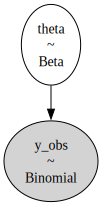

In [3]:
pm.model_to_graphviz(model)

!['beta'](./images/beta_distribution.png)

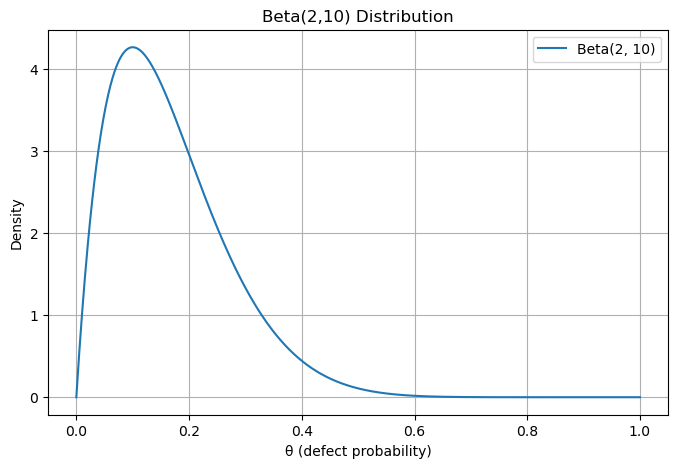

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta
from scipy.stats import binom

# Parameters for the Beta distribution
alpha = 2
beta_param = 10

# Values between 0 and 1
x = np.linspace(0, 1, 1000)
y = beta.pdf(x, alpha, beta_param)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(x, y, label=f'Beta({alpha}, {beta_param})')
plt.title('Beta(2,10) Distribution')
plt.xlabel('θ (defect probability)')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()


In [3]:
with model:
    # Inference: sample from the posterior
    trace = pm.sample(2000, tune=1000, target_accept=0.95, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.


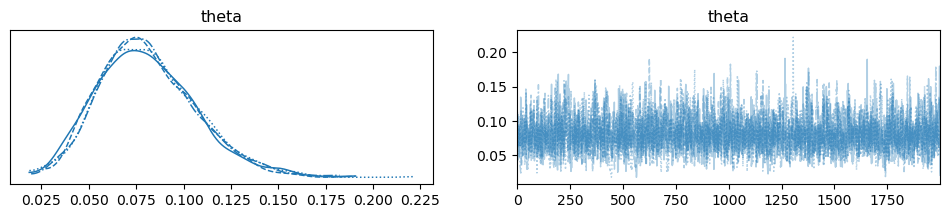

Sampling: [y_obs]


Output()

        mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
theta  0.081  0.026     0.034      0.132      0.001      0.0    2460.0   

       ess_tail  r_hat  
theta    2466.0    1.0  


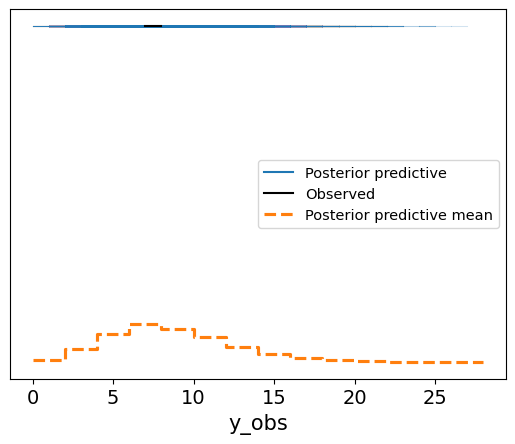

Effective Sample Size (ESS):
<xarray.Dataset> Size: 8B
Dimensions:  ()
Data variables:
    theta    float64 8B 2.46e+03

R-hat:
<xarray.Dataset> Size: 8B
Dimensions:  ()
Data variables:
    theta    float64 8B 1.001


In [4]:
# Model validation and results
# Trace plot
az.plot_trace(trace)
plt.show()

# Summary statistics
summary = az.summary(trace, hdi_prob=0.95)
print(summary)

# Posterior predictive checks
with model:
    ppc = pm.sample_posterior_predictive(trace, random_seed=42)

az.plot_ppc(ppc)
plt.show()

# Effective Sample Size and R-hat (convergence diagnostics)
ess = az.ess(trace)
rhat = az.rhat(trace)
print("Effective Sample Size (ESS):")
print(ess)
print("\nR-hat:")
print(rhat)


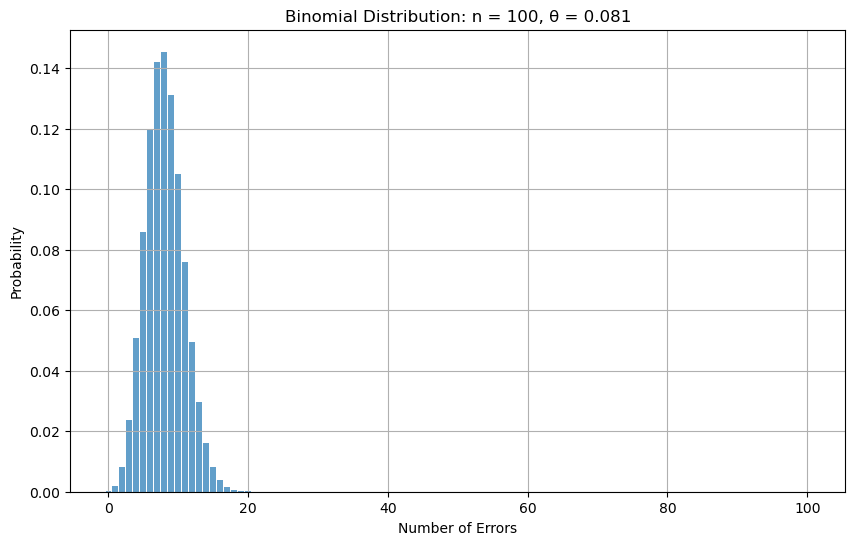

In [6]:
# Parameters
n = 100         # number of trials (e.g., games)
theta = 0.081   # probability of success (e.g., scoring in a game)

# Range of possible goal counts
x = np.arange(0, n+1)

# PMF: Probability Mass Function
pmf = binom.pmf(x, n, theta)

# Plot
plt.figure(figsize=(10, 6))
plt.bar(x, pmf, alpha=0.7)
plt.title(f'Binomial Distribution: n = {n}, θ = {theta}')
plt.xlabel('Number of Errors')
plt.ylabel('Probability')
plt.grid(True)
plt.show()

### Expected results

The posterior for $ \theta $ should be centered somewhere around 7%.

The uncertainty will be visible (maybe 95% HDI from ~3% to ~12%).

Posterior predictive should simulate similar numbers of defects (around 7).

# Modeling Daily Website Visits Based on Marketing Spend

### Problem Statement
A digital marketing team wants to understand how their daily advertising spend influences the number of visits to their website. The number of daily visits is count data (non-negative integers), and the relationship between marketing spend and visits is expected to be nonlinear and multiplicative.

They want to build a Bayesian Poisson regression model to:

Quantify the effect of marketing spend on daily visits.

Estimate uncertainty in the effect size.

Make probabilistic predictions of daily visits given different marketing budgets.

### Synthetic Dataset Generation (Simulating the Problem)



In [7]:
import numpy as np

np.random.seed(42)
n_days = 100000

# Simulate daily marketing spend (in thousands of dollars)
marketing_spend = np.random.normal(5, 2, n_days)  # average spend $5k, std $2k

# True underlying relationship parameters
true_intercept = 0.5
true_beta = 0.3

# Poisson rate (expected visits) increases exponentially with spend
expected_visits = np.exp(true_intercept + true_beta * marketing_spend)

# Simulate daily visits from Poisson distribution
daily_visits = np.random.poisson(lam=expected_visits)



We model the daily visits as Poisson distributed counts with a log-linear relationship to marketing spend:

$$
\text{daily\_visits}_i \sim \text{Poisson}(\lambda_i), \quad \lambda_i = \exp(\alpha + \beta \times \text{marketing\_spend}_i)
$$


α is the intercept (baseline log-rate of visits).

β is the effect of marketing spend on the log-rate of visits.

In [8]:
import pymc as pm
import arviz as az

with pm.Model() as model:
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10)
    
    mu = pm.math.exp(alpha + beta * marketing_spend)
    
    visits_obs = pm.Poisson("visits_obs", mu=mu, observed=daily_visits)
    
    trace = pm.sample(1000, tune=1000, target_accept=0.9, random_seed=42)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.


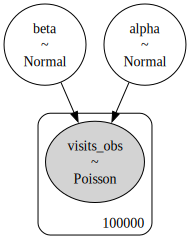

In [9]:
pm.model_to_graphviz(model)

In [10]:
print(az.summary(trace, var_names=["alpha", "beta"]))


        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha  0.503  0.004   0.496    0.510        0.0      0.0     750.0     617.0   
beta   0.300  0.001   0.299    0.301        0.0      0.0     727.0     658.0   

       r_hat  
alpha   1.00  
beta    1.01  


Why Use This Model?

Count data: Poisson regression naturally models counts, unlike linear regression which assumes continuous data.

Nonlinear effect: The log link models multiplicative effects of marketing spend on visits.

Uncertainty quantification: Bayesian inference provides full posterior distributions, allowing for uncertainty estimates and probabilistic predictions.

Scalability: PyMC efficiently handles large datasets with advanced MCMC samplers like NUTS.

In [11]:
with model:
    # Generate posterior predictive samples using the trace (idata)
    idata = pm.sample(draws=1000, tune=1000, random_seed=42, return_inferencedata=True)
    posterior_predictive = pm.sample_posterior_predictive(
        idata,
        var_names=["visits_obs"],       # variables to generate predictions for; use your observed variable's name
        random_seed=42,
        return_inferencedata=True  # returns an InferenceData object compatible with ArviZ
    )




Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.
Sampling: [visits_obs]


Output()

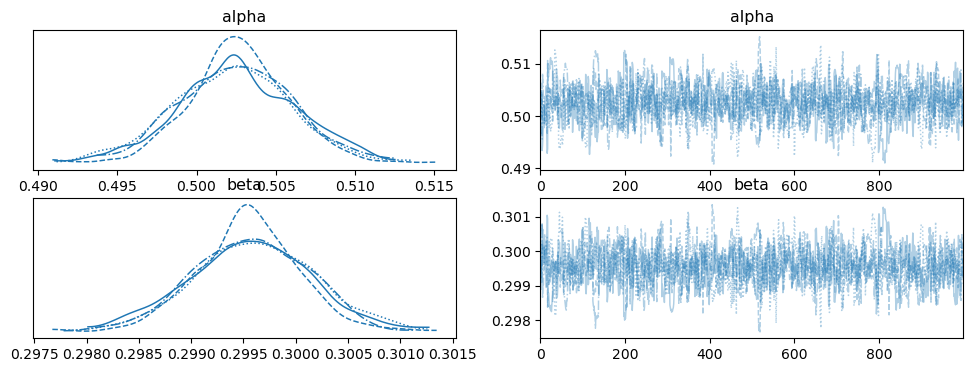

        mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
alpha  0.503  0.004     0.496      0.510        0.0      0.0     750.0   
beta   0.300  0.001     0.299      0.301        0.0      0.0     727.0   

       ess_tail  r_hat  
alpha     617.0   1.00  
beta      658.0   1.01  


In [12]:
# Trace plot
az.plot_trace(trace)
plt.show()

# Summary statistics
summary = az.summary(trace, hdi_prob=0.95)
print(summary)

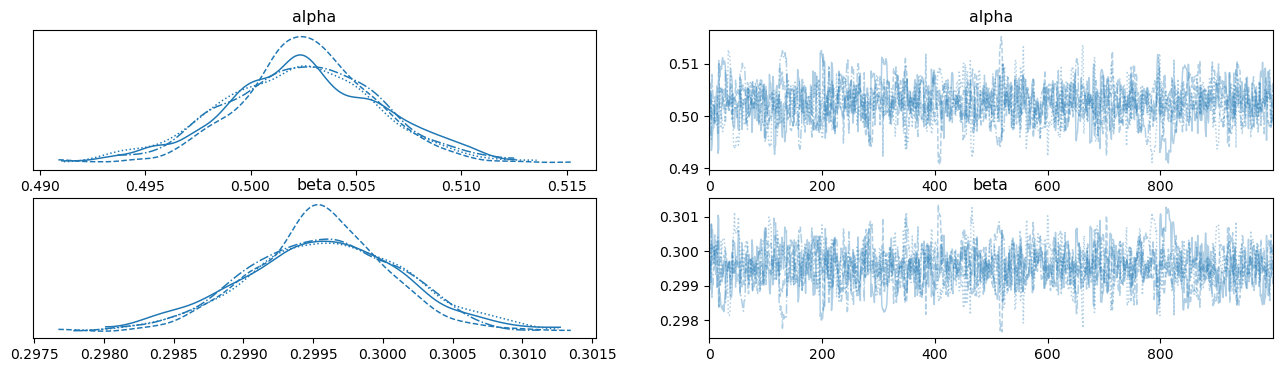

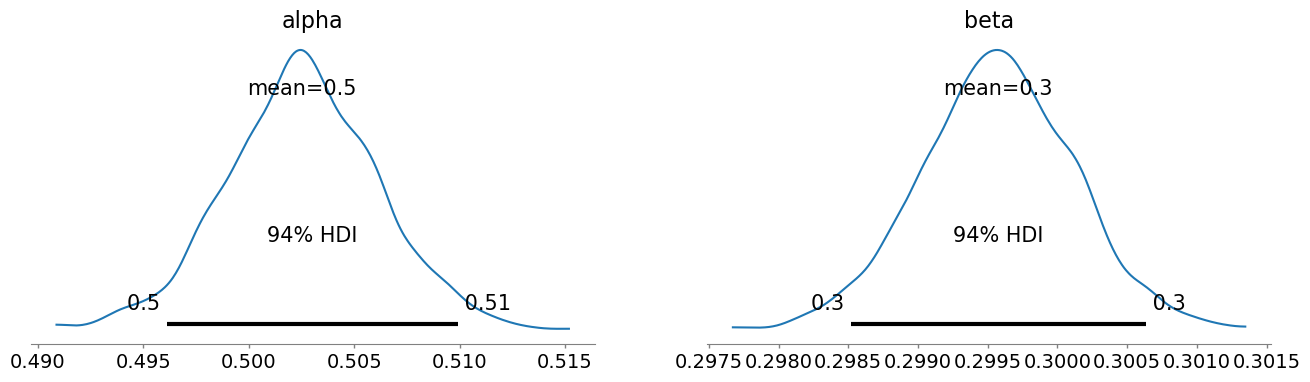

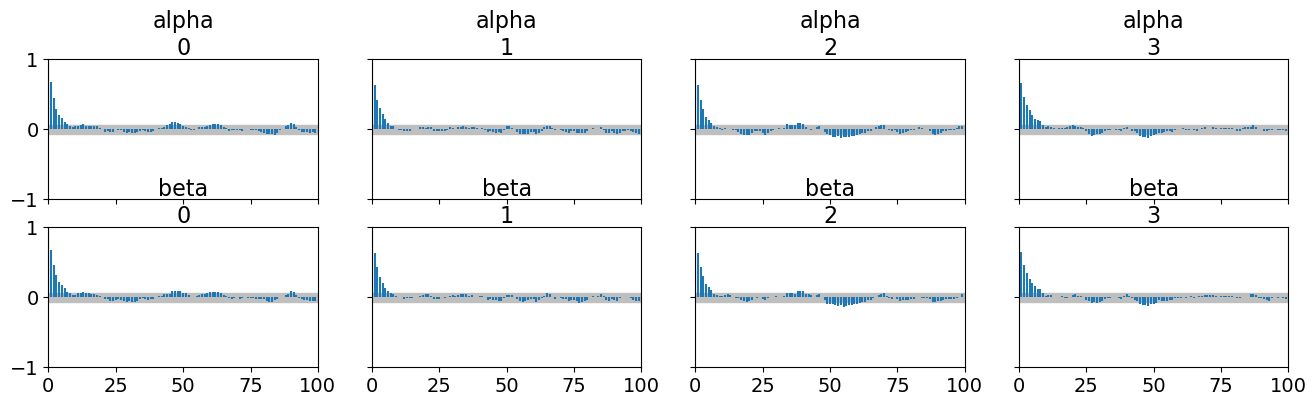

In [14]:
az.plot_trace(data=trace, var_names=["alpha", "beta"],figsize=(16,4))
az.plot_posterior(data=trace,var_names=["alpha", "beta"],figsize=(16,4))
az.plot_autocorr(data=trace, var_names=["alpha", "beta"],figsize=(16,4));

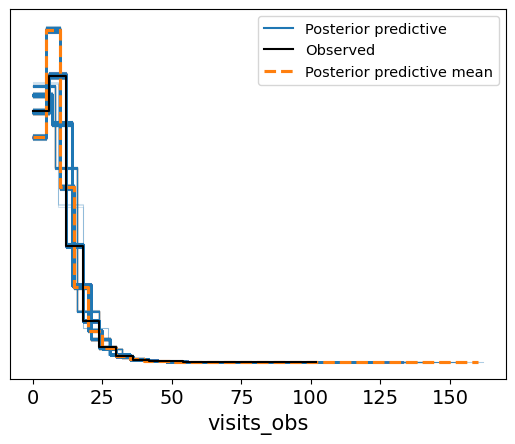

In [13]:
az.plot_ppc(posterior_predictive)
plt.show()

# Bayesian Poisson Regression Exercise with PyMC

Problem Setup

You're provided with a numerical dataset representing observed sales volumes influenced by different numerical predictors such as advertising spend, price, and store size. The dataset includes:

Advertising spend (in thousands of dollars)

Product price (in dollars)

Store size (in square feet)

Number of units sold

### Sample Data (example)

Here's an example dataset snippet you can use for demonstration purposes:

In [16]:
import pandas as pd

data = {
    'Advertising Spend': [20, 30, 40, 50, 60, 70],
    'Product Price': [5, 4.5, 4, 3.5, 3, 2.5],
    'Store Size': [1500, 2000, 2500, 3000, 3500, 4000],
    'Units Sold': [200, 250, 300, 350, 400, 450]
}

df = pd.DataFrame(data)

### Objective

Construct a Bayesian Poisson regression model to estimate the expected number of units sold based on the predictors provided (advertising spend, product price, store size).

In [17]:
import pymc as pm
import numpy as np

with pm.Model() as poisson_regression:
    # Predictors
    advertising = df['Advertising Spend'].values
    price = df['Product Price'].values
    size = df['Store Size'].values

    # Priors for coefficients
    beta_advertising = pm.Normal('beta_advertising', mu=0, sigma=1)
    beta_price = pm.Normal('beta_price', mu=0, sigma=1)
    beta_size = pm.Normal('beta_size', mu=0, sigma=1)
    intercept = pm.Normal('intercept', mu=0, sigma=1)

    # Expected units sold
    lambda_ = intercept + beta_advertising * advertising + beta_price * price + beta_size * size

    # Likelihood
    units_sold_obs = df['Units Sold'].values
    units_sold = pm.Poisson('units_sold', mu=lambda_, observed=units_sold_obs)


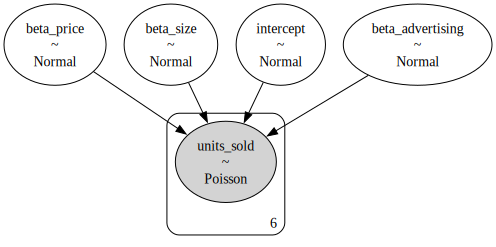

In [26]:
pm.model_to_graphviz(poisson_regression)

In [20]:
import pytensor
pytensor.config.cxx = '/usr/bin/clang++'
with poisson_regression:
    trace_pr = pm.sample(2000, tune=1000, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_advertising, beta_price, beta_size, intercept]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 5 seconds.


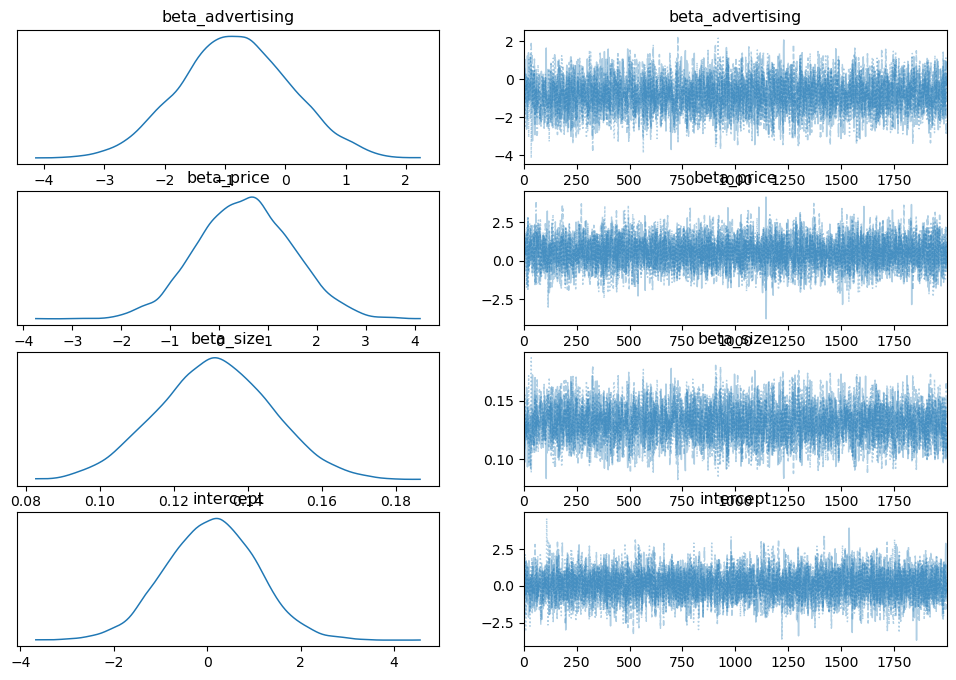

                   mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
beta_advertising -0.831  0.910    -2.677      0.886      0.015    0.011   
beta_price        0.526  0.958    -1.210      2.528      0.013    0.011   
beta_size         0.131  0.015     0.101      0.161      0.000    0.000   
intercept         0.082  0.977    -1.805      2.026      0.013    0.013   

                  ess_bulk  ess_tail  r_hat  
beta_advertising    3591.0    3944.0    1.0  
beta_price          5238.0    4511.0    1.0  
beta_size           3571.0    3896.0    1.0  
intercept           5766.0    4234.0    1.0  


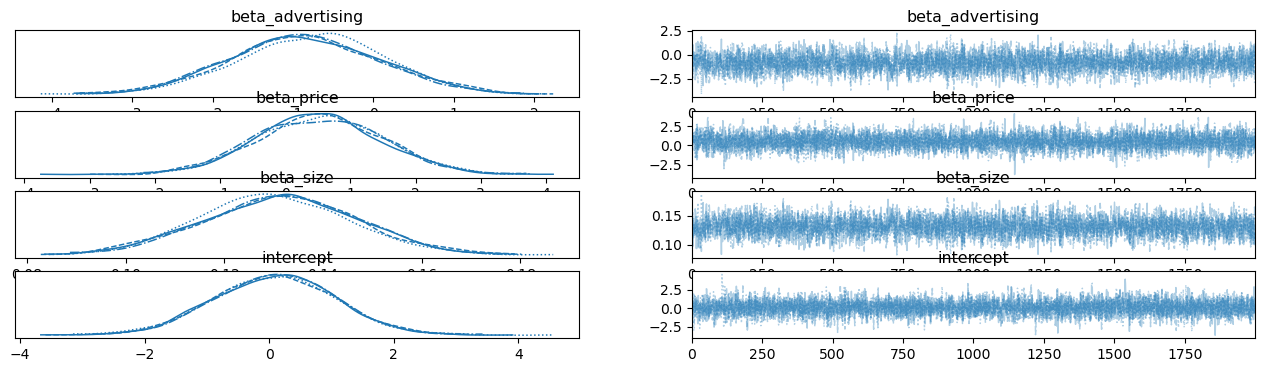

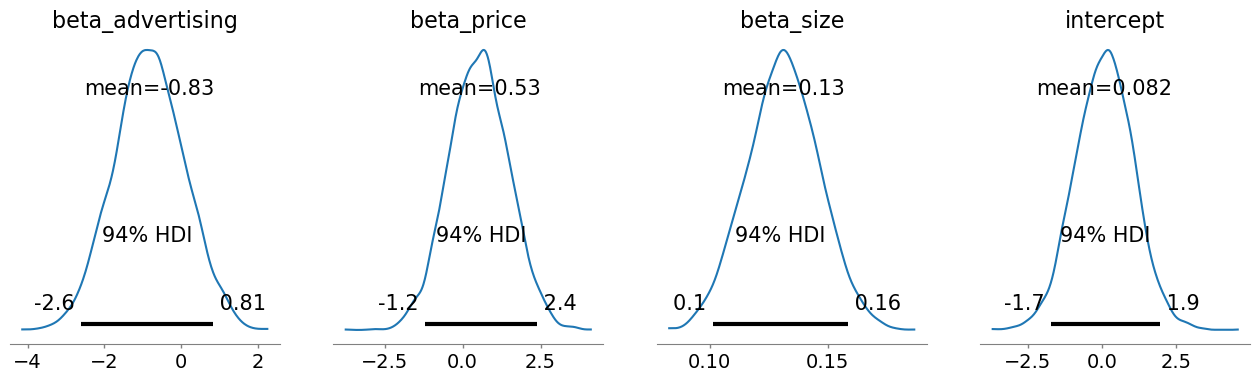

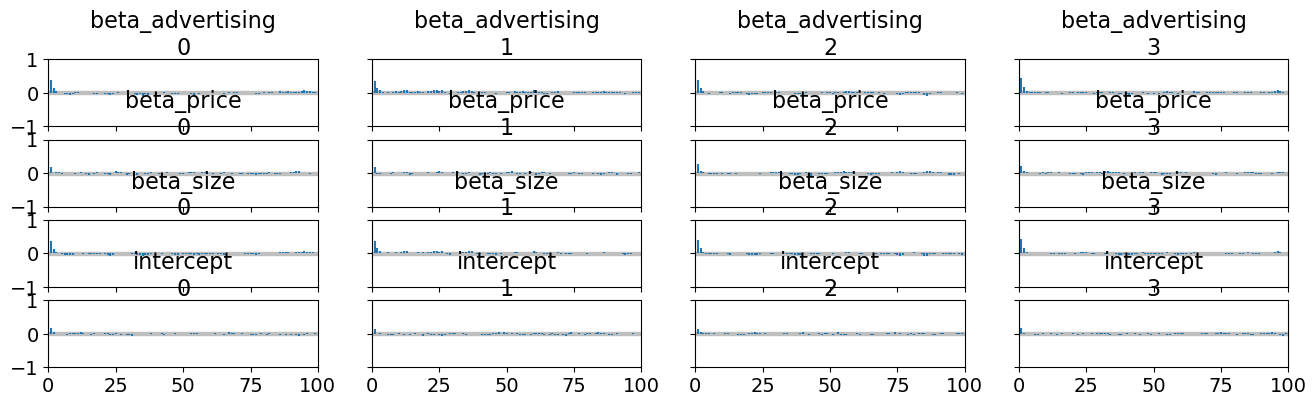

In [22]:
# Model validation and results
# Trace plot
az.plot_trace(trace_pr, combined=True);
plt.show()

# Summary statistics
summary = az.summary(trace_pr, hdi_prob=0.95)
print(summary)

az.plot_trace(data=trace_pr,figsize=(16,4))
az.plot_posterior(data=trace_pr,figsize=(16,4))
az.plot_autocorr(data=trace_pr, figsize=(16,4));

# Bayesian Hierarchical Modeling Exercise with PyMC

## Problem Setup

You're provided with a large dataset containing the observed number of accidents at multiple traffic intersections across various cities over several years. The dataset includes:

Intersection ID

City

Year

Traffic volume (vehicles/day)

Number of accidents observed

Sample Data (example)

Here's an example dataset snippet you can use for demonstration purposes:

In [23]:
import pandas as pd

data = {
    'Intersection ID': ['A1', 'A2', 'B1', 'B2', 'C1', 'C2'],
    'City': ['CityA', 'CityA', 'CityB', 'CityB', 'CityC', 'CityC'],
    'Year': [2020, 2020, 2021, 2021, 2022, 2022],
    'Traffic volume (vehicles/day)': [1000, 1500, 1200, 1100, 1300, 1250],
    'Number of accidents observed': [5, 7, 6, 4, 8, 5]
}

df = pd.DataFrame(data)

### Objective

Your task is to construct a Bayesian hierarchical Poisson model to estimate the underlying accident rate for each intersection, considering variations across cities and individual intersections. Hierarchical models are ideal here since they allow borrowing of strength across intersections and cities, improving individual estimates especially where data is sparse.

In [26]:
import pymc as pm
import numpy as np

with pm.Model() as hierarchical_model:
    city_idx, cities = pd.factorize(df['City'])
    intersection_idx, intersections = pd.factorize(df['Intersection ID'])

    # Hyperpriors for city-level parameters
    mu_city = pm.Normal('mu_city', mu=0, sigma=1)
    sigma_city = pm.HalfNormal('sigma_city', sigma=1)

    # City-level parameters
    city_effect = pm.Normal('city_effect', mu=mu_city, sigma=sigma_city, shape=len(cities))

    # Intersection-level parameters
    sigma_intersection = pm.HalfNormal('sigma_intersection', sigma=1)
    intersection_effect = pm.Normal('intersection_effect', mu=city_effect[city_idx], sigma=sigma_intersection, shape=len(intersections))

    # Expected accident rate
    traffic_volume = df['Traffic volume (vehicles/day)'].values
    lambda_ = pm.math.exp(intersection_effect[intersection_idx]) * traffic_volume

    # Likelihood
    accidents_observed = df['Number of accidents observed'].values
    accidents = pm.Poisson('accidents', mu=lambda_, observed=accidents_observed)



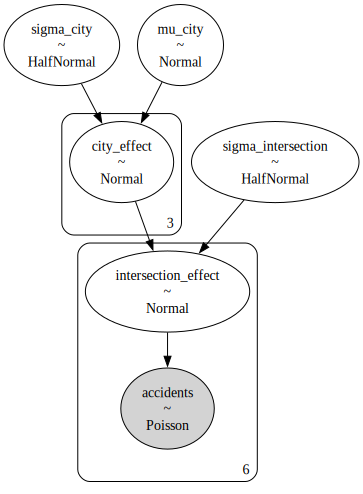

In [27]:
pm.model_to_graphviz(hierarchical_model)

In [28]:
with hierarchical_model:
    trace_hm = pm.sample(2000, tune=1000, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_city, sigma_city, city_effect, sigma_intersection, intersection_effect]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 9 seconds.
There were 445 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


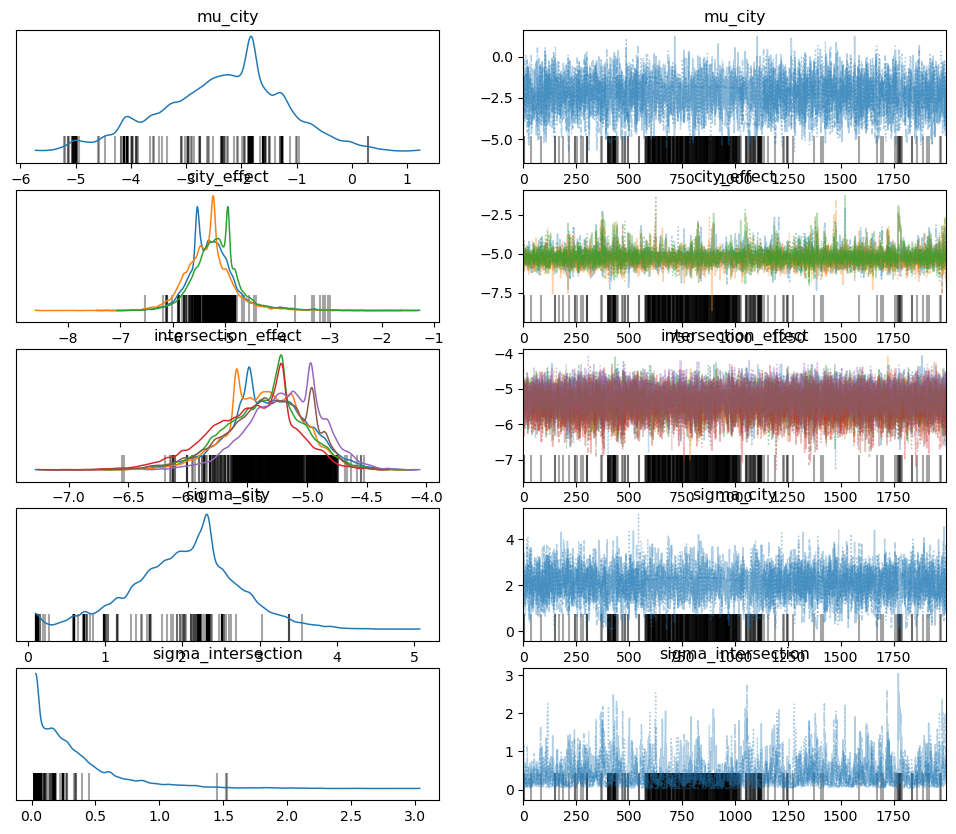

                         mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
mu_city                -2.350  1.121    -4.651     -0.211      0.035    0.030   
city_effect[0]         -5.243  0.469    -6.108     -4.225      0.012    0.008   
city_effect[1]         -5.308  0.479    -6.280     -4.407      0.010    0.007   
city_effect[2]         -5.158  0.463    -6.069     -4.221      0.011    0.008   
intersection_effect[0] -5.325  0.339    -6.034     -4.689      0.007    0.005   
intersection_effect[1] -5.353  0.309    -5.940     -4.733      0.009    0.006   
intersection_effect[2] -5.361  0.338    -6.043     -4.701      0.006    0.005   
intersection_effect[3] -5.461  0.367    -6.194     -4.785      0.012    0.008   
intersection_effect[4] -5.177  0.310    -5.779     -4.583      0.010    0.007   
intersection_effect[5] -5.328  0.355    -6.050     -4.731      0.023    0.017   
sigma_city              2.024  0.698     0.551      3.381      0.024    0.017   
sigma_intersection      0.36

/opt/anaconda3/envs/bayesian/lib/python3.10/site-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (48) in plot_autocorr, generating only 40 plots
  warnings.warn(


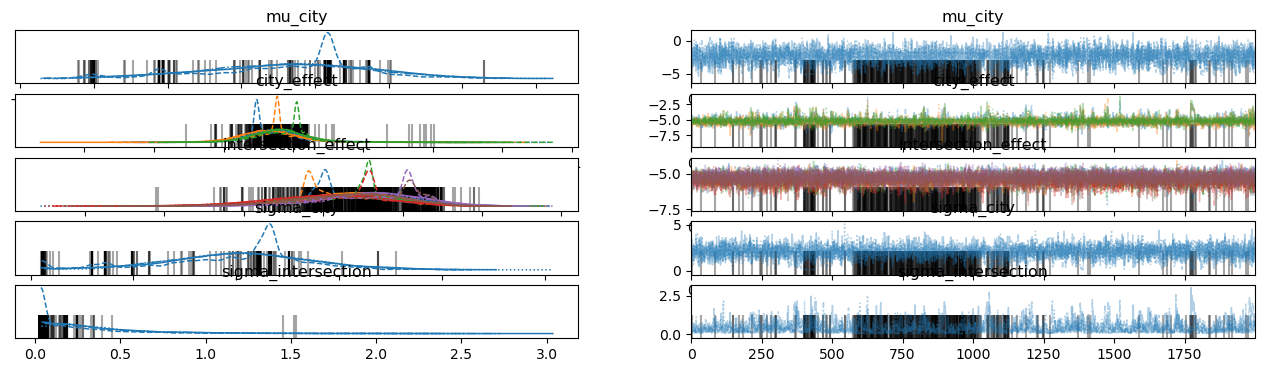

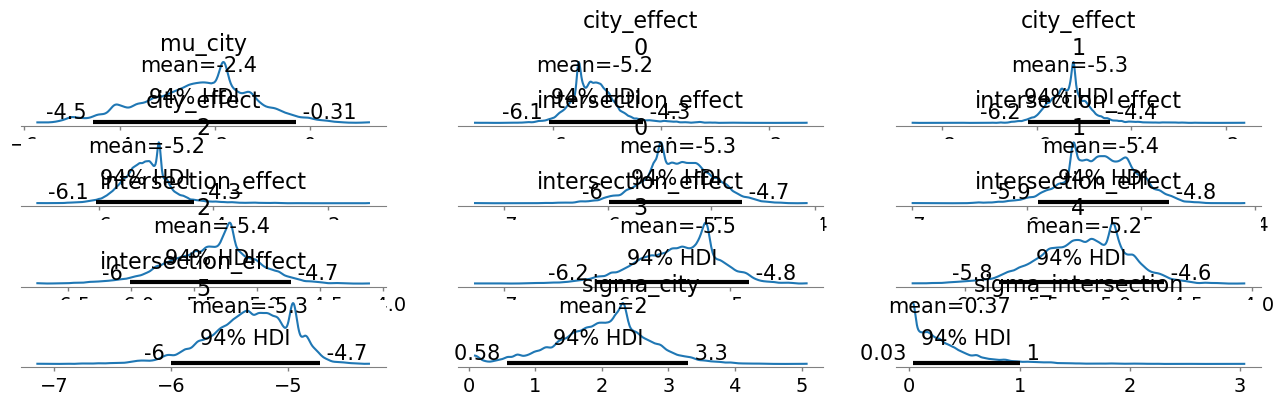

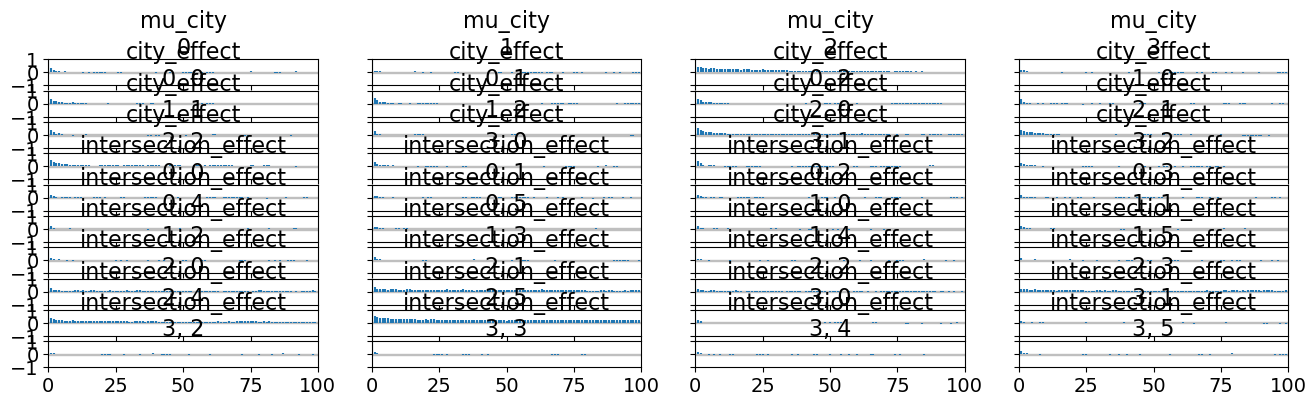

In [29]:
# Model validation and results
# Trace plot
az.plot_trace(trace_hm, combined=True);
plt.show()

# Summary statistics
summary = az.summary(trace_hm, hdi_prob=0.95)
print(summary)


az.plot_trace(data=trace_hm,figsize=(16,4))
az.plot_posterior(data=trace_hm,figsize=(16,4))
az.plot_autocorr(data=trace_hm, figsize=(16,4));